<h1>Module 16 Project Template</h1>

Use the code below to help you analyze the data returned by the MBTA API:

In [20]:
mbtaURL = "https://api-v3.mbta.com/vehicles?filter[route]=1&include=trip"

import urllib.request, json
with urllib.request.urlopen(mbtaURL) as url:
    data = json.loads(url.read().decode())
   
    with open('data.json', 'w') as outfile:
        json.dump(data, outfile)
   
    with open('data.txt', 'w') as outfile:
        json.dump(json.dumps(data, indent=4, sort_keys=True), outfile)
       
    print(json.dumps(data, indent=4, sort_keys=True))


{
    "data": [
        {
            "attributes": {
                "bearing": 0,
                "carriages": [],
                "current_status": "IN_TRANSIT_TO",
                "current_stop_sequence": 12,
                "direction_id": 1,
                "label": "1894",
                "latitude": 42.3484634,
                "longitude": -71.08838068,
                "occupancy_status": "FULL",
                "speed": null,
                "updated_at": "2023-08-15T14:09:59-04:00"
            },
            "id": "y1894",
            "links": {
                "self": "/vehicles/y1894"
            },
            "relationships": {
                "route": {
                    "data": {
                        "id": "1",
                        "type": "route"
                    }
                },
                "stop": {
                    "data": {
                        "id": "79",
                        "type": "stop"
                    }
                },
     

Use the code below to read the data from your MySQL database and store it in a pandas dataframe.  

You you need to install pymysql to run the code:

pip install pymysql

In [21]:
import os
import pymysql
import pandas as pd

host = '127.0.0.1'
port = '3306'
user = 'root'
password = 'MyNewPass'
database = 'MBTAdb'

conn = pymysql.connect(
    host=host,
    port=int(3300),
    user="root",
    passwd=password,
    db=database,
    charset='utf8mb4')

df = pd.read_sql_query("SELECT * FROM mbta_buses",
    conn)

df.tail(10)

C:\Users\najib.abouloifa\AppData\Local\Temp\ipykernel_19588\4176251004.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT * FROM mbta_buses",


,record_num,id,latitude,longitude,occupancy_status,current_status,current_stop_sequence,bearing,direction_id,route_id,stop_id,trip_id,updated_at
16526,16527,y1824,42.332237,-71.075445,MANY_SEATS_AVAILABLE,IN_TRANSIT_TO,5,51,0,1,10003,57345341,2023-08-15 18:09:35
16527,16528,y1742,42.345402,-71.086779,FEW_SEATS_AVAILABLE,IN_TRANSIT_TO,12,340,0,1,91,57345340,2023-08-15 18:09:31
16528,16529,y1894,42.348534,-71.088451,FULL,IN_TRANSIT_TO,12,163,1,1,79,57345823,2023-08-15 18:09:40
16529,16530,y1850,42.373070,-71.117490,MANY_SEATS_AVAILABLE,IN_TRANSIT_TO,1,270,0,1,110,57345337,2023-08-15 18:09:17
16530,16531,y1824,42.332576,-71.074779,MANY_SEATS_AVAILABLE,IN_TRANSIT_TO,6,50,0,1,57,57345341,2023-08-15 18:09:46
16531,16532,y1742,42.345423,-71.086715,FEW_SEATS_AVAILABLE,IN_TRANSIT_TO,12,0,0,1,91,57345340,2023-08-15 18:09:45
16532,16533,y1894,42.348384,-71.088344,FULL,IN_TRANSIT_TO,12,355,1,1,79,57345823,2023-08-15 18:09:53
16533,16534,y1850,42.373070,-71.117490,MANY_SEATS_AVAILABLE,IN_TRANSIT_TO,1,270,0,1,110,57345337,2023-08-15 18:09:17
16534,16535,y1824,42.332638,-71.074570,MANY_SEATS_AVAILABLE,IN_TRANSIT_TO,6,66,0,1,57,57345341,2023-08-15 18:09:56
16535,16536,y1742,42.345409,-71.086708,FEW_SEATS_AVAILABLE,IN_TRANSIT_TO,12,315,0,1,91,57345340,2023-08-15 18:09:57



The code below saves the data as a csv file to the local directory as a backup.

In [22]:
df.to_csv('MBTABusesdata.csv')

<h1>What is the average time it takes for a bus to complete the route</h1>

In [23]:
import numpy as np
from haversine import haversine, Unit
def timedelta(column):
    return (column.max() - column.min()).total_seconds()/60

In [24]:
aggs = {
    'updated_at': ['min', 'max', timedelta],
    'current_stop_sequence':['min','max']
}

In [25]:
def calculate(data):
    Distance = 0
    trip_id = data['trip_id']
    first_stop = data['first_stop_sequence']
    last_stop = data['last_stop_sequence']
    start = tuple([df['latitude'].loc[np.logical_and(df['trip_id']==trip_id,df['current_stop_sequence']== first_stop)].iloc[0],df['longitude'].loc[np.logical_and(df['trip_id']==trip_id,df['current_stop_sequence']== first_stop)].iloc[0]])
    for squence in range(1,last_stop+1):
        try:   
            end = tuple([df['latitude'].loc[np.logical_and(df['trip_id']==trip_id,df['current_stop_sequence']== squence)].iloc[-1],df['longitude'].loc[np.logical_and(df['trip_id']==trip_id,df['current_stop_sequence']== squence)].iloc[-1]])
            Distance += haversine(start, end, unit='km')
            start = end
        except:
            pass
    return Distance

In [26]:
df_bus = df.groupby(['id','trip_id','direction_id']).agg(aggs)
df_bus.columns = ['updated_at_last', 'updated_at_recent', 'trip_time','first_stop_sequence','last_stop_sequence']
df_bus = df_bus[np.logical_and(df_bus['last_stop_sequence']!=1,df_bus['first_stop_sequence']==1)]
df_bus['trip_avergae_time'] = df_bus['trip_time'].mean()
df_bus = df_bus.reset_index()
df_bus['Distance'] = df_bus.apply(calculate,axis = 1)
df_bus

,id,trip_id,direction_id,updated_at_last,updated_at_recent,trip_time,first_stop_sequence,last_stop_sequence,trip_avergae_time,Distance
0,y1733,57345837,1,2023-08-14 21:04:38,2023-08-14 21:21:00,16.366667,1,24,33.396061,3.785454
1,y1733,57345847,1,2023-08-14 22:13:01,2023-08-14 22:42:29,29.466667,1,22,33.396061,6.379685
2,y1742,57345340,0,2023-08-15 17:34:05,2023-08-15 18:09:57,35.866667,1,12,33.396061,5.166855
3,y1774,57345843,1,2023-08-14 21:36:04,2023-08-14 22:19:57,43.883333,1,24,33.396061,11.864198
4,y1777,57345383,0,2023-08-14 21:37:00,2023-08-14 22:16:21,39.350000,1,23,33.396061,12.133021
5,y1777,57345838,1,2023-08-14 21:04:09,2023-08-14 21:29:55,25.766667,1,24,33.396061,4.289855
6,y1790,57346977,1,2023-08-15 15:01:30,2023-08-15 15:39:36,38.100000,1,24,33.396061,11.923688
7,y1794,57345274,0,2023-08-15 11:19:00,2023-08-15 11:52:36,33.600000,1,23,33.396061,12.096011
8,y1794,57345787,1,2023-08-15 10:44:25,2023-08-15 11:17:36,33.183333,1,24,33.396061,12.715424
9,y1794,57345795,1,2023-08-15 12:03:35,2023-08-15 12:39:35,36.000000,1,24,33.396061,11.777232


<h1>Provide a Visualization based on the data</h1>

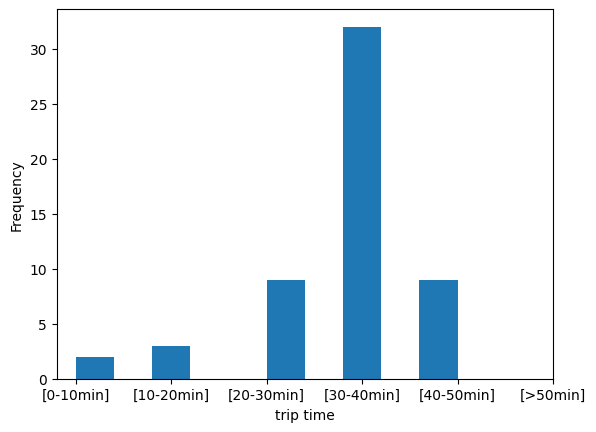

In [27]:
import matplotlib.pyplot as plt
def trip_time(data):
    if data<10:
        return 0
    elif data<20:
        return 1
    elif data<30:
        return 2
    elif data<40:
        return 3
    elif data<50:
        return 4
    else :
        return 5
df_bus['time_by_trip'] = df_bus['trip_time'].apply(trip_time)
df_bus['time_by_trip'].plot.hist(y ='time_by_trip',)
plt.xticks([0,1,2,3,4,5],['[0-10min]','[10-20min]','[20-30min]','[30-40min]','[40-50min]','[>50min]'])
plt.xlabel('trip time')
plt.show()

<h1>Give an estimate of the speed of the bus from current_stop_sequence = 1 to the last  current_stop_sequence. </h1> 

Note: You can use the haversine Python library to calculate the distance between two points, given two longitude and latitude coordinates.

In [28]:
df_bus["Speed"] = df_bus['Distance']/df_bus['trip_time']*60
df_bus["Speed_average"] = df_bus['Speed'].mean()
df_bus

,id,trip_id,direction_id,updated_at_last,updated_at_recent,trip_time,first_stop_sequence,last_stop_sequence,trip_avergae_time,Distance,time_by_trip,Speed,Speed_average
0,y1733,57345837,1,2023-08-14 21:04:38,2023-08-14 21:21:00,16.366667,1,24,33.396061,3.785454,1,13.877429,19.249511
1,y1733,57345847,1,2023-08-14 22:13:01,2023-08-14 22:42:29,29.466667,1,22,33.396061,6.379685,2,12.990310,19.249511
2,y1742,57345340,0,2023-08-15 17:34:05,2023-08-15 18:09:57,35.866667,1,12,33.396061,5.166855,3,8.643438,19.249511
3,y1774,57345843,1,2023-08-14 21:36:04,2023-08-14 22:19:57,43.883333,1,24,33.396061,11.864198,4,16.221463,19.249511
4,y1777,57345383,0,2023-08-14 21:37:00,2023-08-14 22:16:21,39.350000,1,23,33.396061,12.133021,3,18.500159,19.249511
5,y1777,57345838,1,2023-08-14 21:04:09,2023-08-14 21:29:55,25.766667,1,24,33.396061,4.289855,2,9.989313,19.249511
6,y1790,57346977,1,2023-08-15 15:01:30,2023-08-15 15:39:36,38.100000,1,24,33.396061,11.923688,3,18.777461,19.249511
7,y1794,57345274,0,2023-08-15 11:19:00,2023-08-15 11:52:36,33.600000,1,23,33.396061,12.096011,3,21.600020,19.249511
8,y1794,57345787,1,2023-08-15 10:44:25,2023-08-15 11:17:36,33.183333,1,24,33.396061,12.715424,3,22.991224,19.249511
9,y1794,57345795,1,2023-08-15 12:03:35,2023-08-15 12:39:35,36.000000,1,24,33.396061,11.777232,3,19.628721,19.249511
